# SOM test 1

Test the SOM in an harmonic oscillator. I will use the SOM to simulate the wave function evolution in a harmonic potential. Then I compute the expectation values of position and momenta and I compare it with the classical result-


In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import pysom
import numpy as np
# from scipy import sparse
from scipy import io as sio
from scipy import constants
import time
from matplotlib import pyplot as plt
# from scipy.sparse.linalg import eigs
# from scipy.integrate import odeint
# from scipy.integrate import ode

In [3]:
################################################################################
#                                PARAMETERS                                    #
################################################################################

hb = constants.hbar          
pi = constants.pi
m = 40*1.660538921e-27       #mass of 40Ca
omega = 2*pi*2e6          #frequency of the trap


################################################################################
#                                   GRID                                       #
################################################################################

# Parameters
nx = 2**11      #number of points in our grid (powers of 2)
Lx = 1.e-6       #length of the grid
Lx0 = -Lx/2     #minimum value of the grid

# Create the grid
[x, dx, px, dpx] = pysom.grid.grid_def(nx, Lx0, Lx, hb)

In [4]:
################################################################################
#                                INITIAL WF                                    #
################################################################################

# We define a random gaussian displaced from the centre by Lx/3
psi0 = (m*omega/(pi*hb))**(1/4)*np.exp(-m*omega*(x-Lx/3)**2/(2*hb),dtype = np.complex128);
psi0 /= np.sqrt(np.trapz(np.absolute(psi0)**2, x) );

# Define its momentum representation
psip0 = np.fft.fft(psi0*dx)/(2*pi*hb)
psip0 /= np.sqrt(np.trapz(np.absolute(psip0)**2, px) ) 

In [5]:
################################################################################
#                   TIME EVOLUTION PARAMETERS                                  #
################################################################################

# Final time parameters
tf = 75e-6                  #final time
dt = .1e-6                  #required time step
n = int( np.round(tf/dt) )  #number of steps to get to tf
tt = np.linspace(0,tf,n)    #time vector
dt = tt[1]-tt[0]            #actual time step

# Potential en kinetic energy terms
kin = px**2/(2*m)                     #kinetic vector
expkin = np.exp(-1j*dt*kin/(2*hb))    #vector we will apply in the loop
V = 1/2*m*omega**2*x**2               #potential vector


# Initialize the wave functions to psi0 and psip0
psi = np.copy(psi0)
psip = np.copy(psip0)



In [6]:
pysom.propagation.suzuki_trotter(psi, psip, expkin, V, n, nx, x, dx, px, dpx,dt)

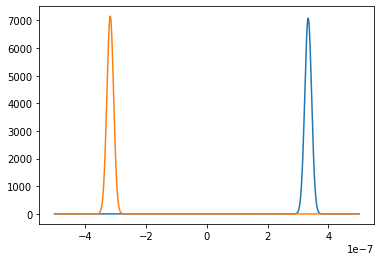

In [8]:
plt.plot(x,np.abs(psi0))
# plt.plot(x,np.real( psi ) )
# plt.plot(x,np.imag( psi ) )
plt.plot(x,np.abs( psi ))
# plt.xlim(-3e-7,-1e-7)